## <div align='center'>NASA Boeing 777-200ER (N577NA) range Estimates for Antarctica</div>

This Jupyter notebook estimates ranges over Antarctica for the NASA Boeing 777 (B777-200ER) a.k.a. 'the triple seven' airborne science laboratory.

### 1) Load required Python modules, processing options, parameters and necessary maps, and define classes/functions:

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import xarray as xr
from matplotlib import colors
from osgeo import gdal
from pyproj import Geod, Transformer
from scipy.interpolate import RegularGridInterpolator, PchipInterpolator

gdal.UseExceptions()

takeoff_penalty	= 15 / 60 #  time it takes to get on track following takeoff, hr
landing_penalty	= 15 / 60 # time it takes to get lined up for landing, hr
time_inc		= 5 / 60 # time increment, hr
decim_bm        = 50 # decimation ratio for BedMachine grid
rad_circle      = np.deg2rad(np.arange(360 + 1))
num_circle      = len(rad_circle)
geoid           = Geod(ellps='WGS84') # geoid instance, here we're using WGS84 ellipsoid

# paths to BedMachine and MOA
path_bm = '/Users/jamacgre/OneDrive - NASA/research/data/antarctica/BedMachine/'
path_moa = '/Users/jamacgre/OneDrive - NASA/research/data/moa/new/'

# aircraft class, with 777 defaults
class Aircraft():
    def __init__(self):
        self.Name              = 'NASA B777-200ER' # aircraft name
        self.ShortName         = '777'             # aircraft short name
        self.MTOW              = 650e3             # maximum take-off weight, lb
        self.OEW               = 321e3             # operating empty weight incl. crew, lb
        self.MissionLoad       = 45e3              # load for mission operations incl. QNCs + instruments, lb
        self.FuelTotal         = 308e3             # fuel total, lb
        self.FuelTotalOp       = 284e3             # operational fuel total (assuming tanks are not completely filed), lb
        self.FuelReserveTime   = 30                # minimum fuel reserve, lb
        self.SpeedCruise       = 460               # high-altitude cruise speed, kt
        self.SpeedLo           = 275               # low-alititude survey speed, kt
        self.SpeedLoPenalty    = 2                 # fuel burn penalty ratio for jet low-flying compared to cruise, dimensionless
        self.ETOPS             = 330               # maximum ETOPS for aircraft type (B777-200ER), min
        self.SpeedETOPS        = 400               # one-engine ETOPS airspeed, kt
        self.SpeedETOPSPenalty = 1.5               # one-engine ETOPS fuel burn "penalty", dimensionless
        
# survey class, empty defaults
class Survey():
    def __init__(self):
        self.DistTransit       = np.nan # transit distance between base and target, m
        self.TimeTransit       = np.nan # transit time, hr
        self.FuelTransitOut    = np.nan # fuel required for transit out to target, lb
        self.FuelTransitReturn = np.nan # fuel required for return to base, lb
        self.FuelTransit       = np.nan # total fuel required for out-and-back transit, lb
        self.RangeSurvey       = np.nan # available survey range, m
        self.TimeSurvey        = np.nan # available survey time, hr
        self.XRangeCircle      = np.empty(num_circle, dtype=float) # projected x of survey range circle, m
        self.YRangeCircle      = np.empty(num_circle, dtype=float) # projected y of survey range circle, m

# survey_range is a function to calculate survey range/time based on aircraft parameters (ac), and EITHER
# already known distance (dist) 
# OR
# base (lat1/lon1) and target (lat2/lon/x2/y2), also need geoid instance (geoid) and vector of circle radians (rad_circle)
def survey_range(ac, **kwargs):
    
    survey = Survey()
    
    if 'dist' not in kwargs:
        _, _, survey.DistTransit = kwargs.get('geoid').inv(kwargs.get('lon1'), 
                                                           kwargs.get('lat1'),
                                                           kwargs.get('lon2'),
                                                           kwargs.get('lat2')) # great-circle transit distance between base and target, m
    else:
        survey.DistTransit = kwargs.get('dist')
        
    survey.TimeTransit = survey.DistTransit / ac.SpeedCruise # transit time, hr
    
    # initialize distance, fuel and load
    dist_curr = 0
    fuel_curr = ac.FuelTotalOp
    load_curr = ac.LoadStart
    
    # add in takeoff penalty
    for takeoff in range(np.round(takeoff_penalty / time_inc).astype(int)):
        fuel_burn_curr = ac.BurnRateHiInterp(load_curr) * time_inc # current fuel burn in lbs = rate (lb/hr) * hr
        fuel_curr -= fuel_burn_curr # fuel weight available - weight burned = weight remaining
        load_curr -= fuel_burn_curr / ac.LoadMax # previous load - load just spent (which was all fuel)
    
    # keep going until you reach target
    while (dist_curr < survey.DistTransit) & (fuel_curr > ac.FuelReserveWt):
        dist_curr += time_inc * ac.SpeedCruise # hr * m/hr = m
        fuel_burn_curr = ac.BurnRateHiInterp(load_curr) * time_inc
        fuel_curr -= fuel_burn_curr
        load_curr -= fuel_burn_curr / ac.LoadMax
    
    survey.FuelTransitOut = ac.FuelTotalOp - fuel_curr # fuel needed to transit out to target, lb
    
    # now reverse, starting from base on return, first adding in landing penalty, but base this on ETOPS
    dist_curr = 0
    fuel_curr = ac.FuelReserveWt
    load_curr = ac.LoadEnd
    
    for landing in range(np.round(landing_penalty / time_inc).astype(int)):
        fuel_burn_curr = ac.BurnRateHiInterp(load_curr) * time_inc
        fuel_curr += fuel_burn_curr
        load_curr += fuel_burn_curr / ac.LoadMax
    
    while dist_curr < survey.DistTransit:
        dist_curr += time_inc * ac.SpeedCruise
        fuel_burn_curr = ac.BurnRateHiInterp(load_curr) * time_inc
        fuel_curr += fuel_burn_curr
        load_curr += fuel_burn_curr / ac.LoadMax
    
    survey.FuelTransitReturn = fuel_curr - ac.FuelReserveWt # fuel needed to get back from target under ETOPS, lb
    
    survey.FuelTransit = survey.FuelTransitOut + survey.FuelTransitReturn # total transit fuel, lb
    
    # stop if too far away to survey
    if survey.FuelTransit >= (ac.FuelTotalOp - ac.FuelReserveWt):
        return survey
    
    # calculate distance & time at survey altitude/speed on-station
    dist_curr = 0
    fuel_curr = ac.FuelTotalOp - survey.FuelTransitOut
    load_curr = ac.LoadStart - (survey.FuelTransitOut / ac.LoadMax)
    
    while (fuel_curr > (survey.FuelTransitReturn + fuel_ETOPS_interp((survey.DistTransit, fuel_curr)))): # keep surveying until it's time to turn around
        dist_curr += time_inc * ac.SpeedLo # now use low-altitude survey speed
        fuel_burn_curr = ac.BurnRateLoInterp(load_curr) * time_inc
        fuel_curr -= fuel_burn_curr
        load_curr -= fuel_burn_curr / ac.LoadMax
    
    survey.RangeSurvey = dist_curr # full range survey
    survey.TimeSurvey = dist_curr / ac.SpeedLo # time for full range survey
    
    if 'dist' not in kwargs:
        survey.XRangeCircle, survey.YRangeCircle = kwargs.get('x2') + (np.cos(kwargs.get('rad_circle')) * (survey.RangeSurvey / 2)), \
                                                   kwargs.get('y2') + (np.sin(kwargs.get('rad_circle')) * (survey.RangeSurvey / 2)) # out-and-back range-to-target circle, projected x/y, m
    
    return survey

# fuel needed for ETOPS return
def fuel_ETOPS(ac, dist_transit, fuel_curr, load_curr, time_inc):
    fuel_start = fuel_curr
    dist_return = dist_transit
    while dist_return > 0:
        dist_return -= time_inc * ac.SpeedETOPS
        fuel_burn_curr = (ac.BurnRateHiInterp(load_curr) / ac.SpeedETOPSPenalty) * time_inc
        fuel_curr -= fuel_burn_curr
        load_curr -= fuel_burn_curr / ac.LoadMax
    fuel_return = fuel_start - fuel_curr # fuel needed for return is what we started with minus what's left
    return fuel_return

### 2) Load BedMachine mask, MOA and associated products

In [2]:
# BedMachine Antarctica v3 file name, https://nsidc.org/data/nsidc-0756/versions/3
file_bm = 'BedMachineAntarctica-v3.nc'

bm = xr.open_dataset(path_bm + file_bm)

# extract x/y
x_bm = bm.x.values.astype(np.float32)
y_bm = bm.y.values.astype(np.float32)
xx_bm, yy_bm = np.meshgrid(x_bm, y_bm)

# decimate x/y and get lat/lon
x_decim, y_decim = x_bm[::decim_bm], y_bm[::decim_bm]
xx_decim, yy_decim = np.meshgrid(x_decim, y_decim)
EPSG3031_to_WGS84 = Transformer.from_crs('EPSG:3031', 'EPSG:4326')
lat_decim, lon_decim = EPSG3031_to_WGS84.transform(xx_decim, yy_decim)

# simplify mask
mask_bm = bm['mask'].values
mask_bm[mask_bm > 0] = 1
mask_bm_decim = mask_bm[::decim_bm, ::decim_bm].astype(bool)

bm.close()

# MOA 2008-9 mosaic/coastline/grounding-line/islands in EPSG:3031 already, https://nsidc.org/data/nsidc-0593/versions/2 and https://www.usap-dc.org/view/dataset/609593
file_moa = 'moa750_2009_hp1_v1.1.tif'
file_coastline = 'moa_2009_coastline_v1.1.shp'
file_grounding_line = 'moa_2009_groundingline_v1.1.shp'
file_islands = 'moa_2009_islands_v1.1.shp'

# load/extract MOA mosaic and get x/y limits
moa_inst = gdal.Open(path_moa + file_moa)
moa = moa_inst.GetRasterBand(1).ReadAsArray()
moa_gt = moa_inst.GetGeoTransform()
moa_x_sz = moa_inst.RasterXSize
moa_y_sz = moa_inst.RasterYSize
x_min_moa, x_max_moa, y_min_moa, y_max_moa = moa_gt[0], moa_gt[0] + (moa_gt[1] * moa_x_sz), moa_gt[3], moa_gt[3] + (moa_gt[5] * moa_y_sz)
moa_inst.Close()

# load MOA 2008-9 coastline, grounding line and islands
moa_cl = gpd.read_file(path_moa + file_coastline)
moa_gl = gpd.read_file(path_moa + file_grounding_line)
moa_il = gpd.read_file(path_moa + file_islands)

### 3) Further work on aircraft performance parameters

In [5]:
# create return variable 'ac' as an Aircraft class with fields populated
ac = Aircraft()

# 777 specific stats from https://community.infiniteflight.com/t/your-guide-to-fuel-burn-and-cruising-altitudes-in-the-new-777-family-ignore-777f/488605
load_range_ref = np.arange(0.1, (1.0 + 0.1), 0.1)
fuel_burn_per_load = np.vstack((load_range_ref,
                                (1e3 * np.array((8.5, 9.0, 10.4, 10.9, 11.8, 12.4, 13.2, 14.1, 14.9, 15.8))),
                                (1e3 * np.array((10.0, 10.5, 11.7, 12.3, 12.2, 12.9, 13.9, 14.6, 15.7, 16.7))))) # row 1: percentage load; row 2: lowest burn rate in lbs/hr; row 3: lbs/hr higest of burn rates at that load
fuel_burn_per_load = np.vstack((fuel_burn_per_load, 
                                np.mean(fuel_burn_per_load[1:3, :], axis=0))) # mean of high and low

# update parameters and calculate more as needed
ac.SpeedCruise *= 1.852e3 # convert from kt to m/hr
ac.SpeedLo *= 1.852e3
ac.SpeedETOPS *= 1.852e3
ac.WtStart = ac.OEW + ac.MissionLoad + ac.FuelTotalOp # total starting weight, lb
ac.WtSpare = ac.MTOW - ac.WtStart # spare (unused) weight, lb
if ac.WtSpare < 0: # need some spare weight!
    print(ac.Name + ' too heavy!!! (starting weight > MTOW)')
ac.LoadMax = ac.MTOW - ac.OEW # max load, lb
ac.BurnRateHiRange = fuel_burn_per_load[3, :] # using mean of internet values from above
ac.BurnRateLoRange = ac.SpeedLoPenalty * ac.BurnRateHiRange # penalty for low-flying with jet, based on G-V experience
ac.BurnRateHiInterp = PchipInterpolator(load_range_ref, 
                                        ac.BurnRateHiRange, 
                                        extrapolate=True)
ac.BurnRateLoInterp = PchipInterpolator(load_range_ref, 
                                        ac.BurnRateLoRange, 
                                        extrapolate=True)
ac.FuelReserveWt = (ac.FuelReserveTime / 60) * ac.BurnRateHiInterp((ac.OEW + ac.MissionLoad + (0.2 * ac.FuelTotalOp)) / ac.LoadMax) # assume reserve only needed at lower load, lb
ac.WtEnd = ac.OEW + ac.MissionLoad + ac.FuelReserveWt # weight at end assuming we still have reserve, lb
ac.LoadStart = (ac.WtStart - ac.OEW) / ac.LoadMax # load ratio at start, dimensionless
ac.LoadEnd = (ac.WtEnd  - ac.OEW) / ac.LoadMax # load ratio at end, dimensionless
ac.RangeETOPS = (ac.ETOPS / 60) * ac.SpeedETOPS # maximum range based on ETOPS rules, m

# generate 2-D interpolant for distance/fuel and ETOPS 
dist_inc = 50e3 # distance increment to test
dist_ETOPS_test = np.arange(dist_inc, ac.RangeETOPS + dist_inc, dist_inc)
fuel_ETOPS_test = np.linspace(ac.FuelReserveWt, ac.FuelTotalOp, len(dist_ETOPS_test))
load_ETOPS_test = (ac.OEW + ac.MissionLoad + ac.FuelReserveWt + fuel_ETOPS_test) / ac.LoadMax
fuel_ETOPS_arr = np.full((len(dist_ETOPS_test), len(fuel_ETOPS_test)), np.nan)
for i, dist in enumerate(dist_ETOPS_test):
    for j, fuel in enumerate(fuel_ETOPS_test):
        fuel_ETOPS_arr[i, j] = fuel_ETOPS(ac, dist, fuel, load_ETOPS_test[j], time_inc)
fuel_ETOPS_interp = RegularGridInterpolator((dist_ETOPS_test, fuel_ETOPS_test), fuel_ETOPS_arr, bounds_error=False, fill_value=None) # 2-D linear interpolant for ETOPS fuel calculation



In [9]:
ac.RangeETOPS/1e3

4074.4

### 4) Load bases of operation

In [4]:
file_base = 'bases_of_operation.csv'
base_df = pd.read_csv(file_base)

# not needed here but is good practice: wrap longitudes to ±180° for exporting geographic coordinates 
# 0° to 360° is not supported for GeoPackage (GPKG) format    
base_df['Longitude'] = np.mod(base_df['Longitude'] - 180.0, 360.0) - 180.0

base_gdf = gpd.GeoDataFrame(base_df,
                            geometry=gpd.points_from_xy(base_df['Longitude'], base_df['Latitude']))
# set up the coordinate system for GeoDataPackage
base_gdf = base_gdf.set_crs('EPSG:4326')
# save GeoDataPackage if desired
base_gdf.to_file(file_base.replace('.csv', '.gpkg'), 
                 driver='GPKG')

num_base = len(base_gdf)

base_gdf

,Name,Country,CountryNice,ICAO,Latitude,Longitude,Color,geometry
0,Ushuaia,ARG,Argentina,SAWH,-54.84,-68.30,r,POINT (-68.3 -54.84)
1,Hobart,AUS,Australia,YMHB,-42.84,147.51,b,POINT (147.51 -42.84)
2,Cape Town,ZAF,South Africa,FACT,-33.97,18.60,y,POINT (18.6 -33.97)


### 5) Load example targets

In [5]:
file_target = '2019_Antarctic_targets.kml'

target_gdf = gpd.read_file(file_target, 
                           columns=['Name', 'geometry'])
target_gdf.geometry = target_gdf.geometry.force_2d() # remove z

for target_to_remove in ['88S traverse center', 'Rennick GZ', 'Cook GZ', 'Ninnis GZ', 'Français GZ', 'Underwood GZ', 'Conger GZ', 'Dibble GZ']:
    target_gdf = target_gdf.drop(target_gdf[target_gdf['Name'] == target_to_remove].index)
target_gdf.reset_index(inplace=True)

num_target = len(target_gdf)

target_gdf_proj = target_gdf.copy()
target_gdf_proj = target_gdf.to_crs(epsg=3031)

target_gdf
target_gdf_proj

,index,Name,geometry
0,0,Troll,POINT (87112.277 1967918.683)
1,1,Recovery GZ,POINT (-583397.502 781814.311)
2,2,South Pole,POINT (0 0)
3,4,Matusevich GZ,POINT (859082.221 -2081339.972)
4,7,Mertz GZ,POINT (1424850.879 -1971936.641)
5,10,Frost GZ,POINT (1954047.797 -1597331.435)
6,11,Totten GZ,POINT (2268762.737 -1083385.346)
7,14,Denman GZ,POINT (2525397.732 -412600.695)
8,15,West IS,POINT (2583394.521 162588.392)
9,16,Sør Rondane GZ,POINT (930999.871 1858463.154)


### 6) Calculate range-at-target survey distance and time

In [6]:
survey = [None] * num_base

# loop through each base then each target
for base in range(num_base):
    
    survey[base] = [None] * num_target
    
    for target in range(num_target):
        
        survey[base][target] = survey_range(ac, 
                                            lat1=base_gdf.geometry[base].y, 
                                            lon1=base_gdf.geometry[base].x, 
                                            lat2=target_gdf.geometry[target].y, 
                                            lon2=target_gdf.geometry[target].x, 
                                            x2=target_gdf_proj.geometry[target].x, 
                                            y2=target_gdf_proj.geometry[target].y, 
                                            geoid=geoid, 
                                            rad_circle=rad_circle)

### 7) Calculate Antarctic-wide gridded range-at-target survey distance and time

In [7]:
decim_shape = (mask_bm_decim.shape[0], mask_bm_decim.shape[1], num_base)
dist_grd, range_grd, time_grd, time_transit_grd, dist_ETOPS = np.full(decim_shape, np.nan), \
                                                              np.full(decim_shape, np.nan), \
                                                              np.full(decim_shape, np.nan), \
                                                              np.full(decim_shape, np.nan), \
                                                              np.full(decim_shape, True)

# great-circle distance between each base and decimated BedMachine grid
for base in range(num_base):
    _, _, dist_grd[:, :, base] = geoid.inv(np.full(decim_shape[0:2], base_gdf.geometry[base].x), 
                                           np.full(decim_shape[0:2], base_gdf.geometry[base].y), 
                                           lon_decim,
                                           lat_decim)

dist_ETOPS[dist_grd > ac.RangeETOPS] = False # ETOPS distance evaluation for easy contouring later on

# indices where ice is present so we'll test them
ind_mask = np.argwhere(mask_bm_decim)

for pt in range(len(ind_mask)):
    
    if pt % 1e3 == 0:
        print(str(1e2 * (pt / len(ind_mask))) + '%...')
    
    for base in range(num_base):
        
        survey_curr = survey_range(ac, 
                                   dist=dist_grd[ind_mask[pt][0], ind_mask[pt][1], base])        
        
        range_grd[ind_mask[pt][0], ind_mask[pt][1], base] = survey_curr.RangeSurvey
        time_grd[ind_mask[pt][0], ind_mask[pt][1], base] = survey_curr.TimeSurvey
        time_transit_grd[ind_mask[pt][0], ind_mask[pt][1], base] = survey_curr.TimeTransit

0.0%...
4.597489770585261%...
9.194979541170522%...
13.79246931175578%...
18.389959082341043%...
22.987448852926303%...
27.58493862351156%...
32.182428394096824%...
36.77991816468209%...
41.37740793526735%...
45.974897705852605%...
50.57238747643786%...
55.16987724702312%...
59.767367017608386%...
64.36485678819365%...
68.9623465587789%...
73.55983632936417%...
78.15732609994943%...
82.7548158705347%...
87.35230564111995%...
91.94979541170521%...
96.54728518229047%...


### 8) Plot range-to-target grids

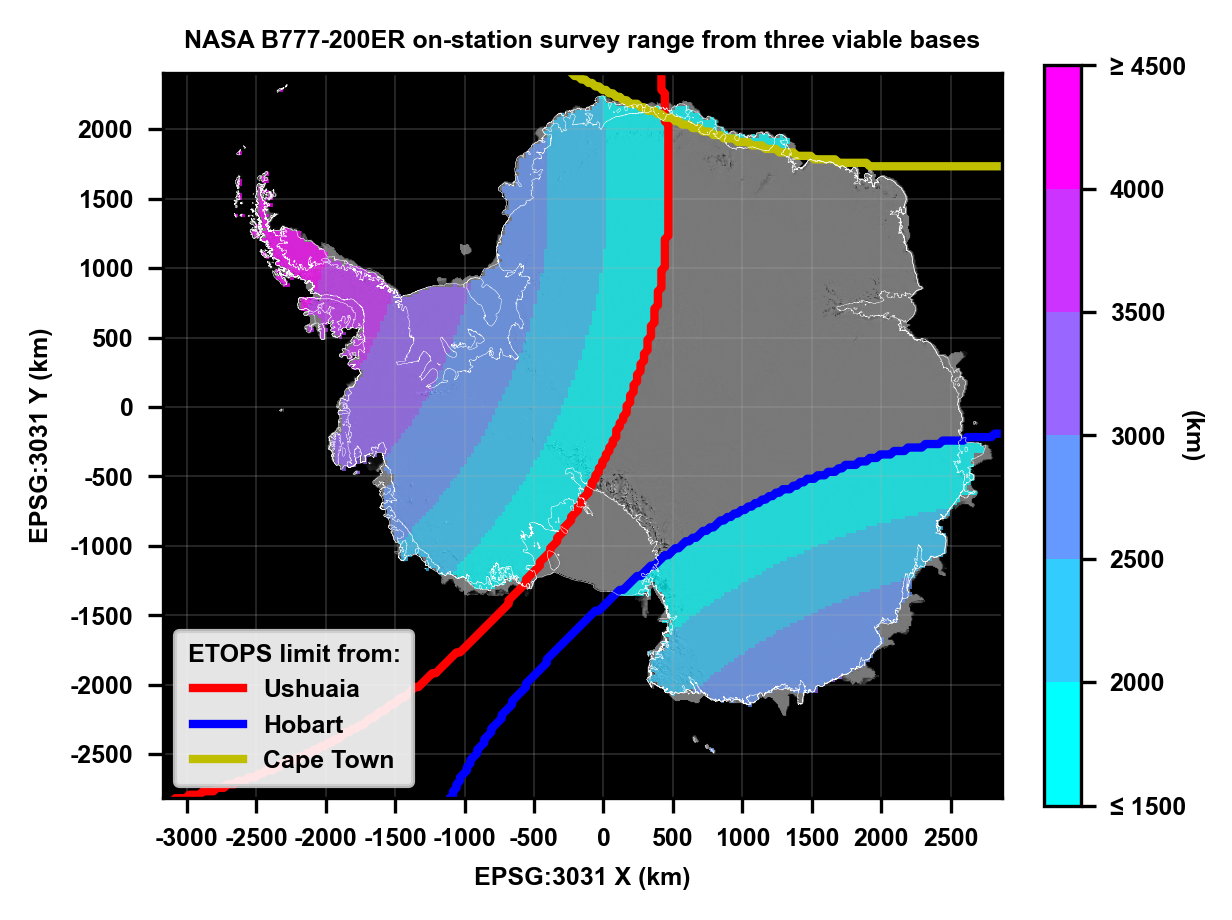

In [15]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size']   = 6
plt.rcParams['font.weight'] = 'bold'

num_color = 6
range_set = np.linspace(1.5e3, 4.5e3, 1 + num_color)
cmap = plt.colormaps['cool'].resampled(num_color)
fig = plt.figure(figsize=(4, 4), dpi=300, facecolor='w', layout='constrained')
ax = plt.subplot(1, 1, 1)
plt.imshow(moa[::10, ::10], 
           extent=(x_min_moa, x_max_moa, y_max_moa, y_min_moa), 
           aspect='equal', 
           cmap='gray')
ims, pc = [None] * num_base, [None] * num_base
for base in range(num_base):
    alpha_curr = np.full(range_grd.shape[0:2], 0.7)
    alpha_curr[dist_grd[:, :, base] > ac.RangeETOPS] = 0
    ims[base] = plt.imshow(range_grd[:, :, base] / 1e3, 
                           extent=(np.min(x_bm), np.max(x_bm), np.min(y_bm), np.max(y_bm)), 
                           aspect='equal', 
                           cmap=colors.ListedColormap(cmap(range(num_color))), 
                           vmin=range_set[0],
                           vmax=range_set[-1],
                           alpha=alpha_curr)
    plt.contour(x_decim, y_decim, dist_ETOPS[:, :, base], levels=[0, 1], colors=base_gdf.Color[base], linewidths=2, linestyles='-')
    pc[base], = plt.plot(np.nan, np.nan, color=base_gdf.Color[base], linewidth=2)
plt.axis(np.array((x_min_moa, x_max_moa, y_max_moa, y_min_moa)))
plt.clim(range_set[[0, -1]])
moa_gl.boundary.plot(color='w', ax=ax, linewidth=0.1)
moa_cl.boundary.plot(color='w', ax=ax, linewidth=0.1)
moa_il.boundary.plot(color='w', ax=ax, linewidth=0.1)
plt.title(ac.Name + ' on-station survey range from three viable bases', font='Arial', size=6, fontweight='bold')
plt.xticks(ticks=np.arange(-3e6, 2.5e6 + 5e5, 5e5), labels=np.arange(-3e3, 2.5e3 + 5e2, 5e2).astype(int).astype(str), font='Arial', size=6, fontweight='bold')
plt.yticks(ticks=np.arange(-2.5e6, 2.0e6 + 5e5, 5e5), labels=np.arange(-2.5e3, 2.0e3 + 5e2, 5e2).astype(int).astype(str), font='Arial', size=6, fontweight='bold')
plt.xlabel('EPSG:3031 X (km)', font='Arial', size=6, fontweight='bold')
plt.ylabel('EPSG:3031 Y (km)', font='Arial', size=6, fontweight='bold')
plt.gca().axes.label_outer()
# plt.tick_params(bottom=False, left=False)
plt.grid(linewidth=0.1)
cb_label = range_set.astype(int).astype(str)
cb_label[0] = '≤ ' + cb_label[0]
cb_label[-1] = '≥ ' + cb_label[-1]
cb = plt.colorbar(ims[0], shrink=0.63)
cb.set_ticks(range_set, labels=cb_label, font='Arial', fontsize=6)
cb.set_label('(km)', rotation=270, fontweight='bold')
plt.legend(pc, base_gdf.Name, title='ETOPS limit from:', prop={'family':'Arial', 'size':6, 'weight':'bold'}, borderpad=0.5, loc='lower left', framealpha=0.9)
plt.show()

In [ ]:
# OLD OLD OLD

fig, ax = plt.subplots(figsize=(4, 4), dpi=300, facecolor='w', layout='constrained')
plt.imshow(moa[::10, ::10], extent=(x_min_moa, x_max_moa, y_max_moa, y_min_moa), aspect='equal', cmap='gray')
plt.axis(np.array((x_min_moa, x_max_moa, y_max_moa, y_min_moa)))
moa_gl.boundary.plot(color='w', ax=ax, linewidth=0.25)
moa_cl.boundary.plot(color='w', ax=ax, linewidth=0.25)
moa_il.boundary.plot(color='w', ax=ax, linewidth=0.25)
plt.plot(-2.5e6, -2e6, 'wx', linewidth=3)
plt.plot((-2.5e6 + (500e3 * np.cos(rad_circle))), (-2e6 + (500e3 * np.sin(rad_circle))), color='w', linestyle='--', linewidth=1)
plt.text(-2.5e6, (-2e6 + 700e3), '500-km\n' + 'survey radius', color='w', font='Arial', size=6, fontweight='bold', horizontalalignment='center')
p_base = [None] * num_base
for base in range(num_base):
    p_base[base], = plt.plot(0, 0, linewidth=1, color=base_gdf.Color[base])
    for target in range(num_target):
        if survey[base][target].RangeSurvey != np.nan:
            plt.plot(survey[base][target].XRangeCircle,
                     survey[base][target].YRangeCircle,
                     linewidth=1,
                     color=base_gdf.Color[base])
for target in range(num_target):
    plt.plot(target_gdf_proj.geometry[target].x, target_gdf_proj.geometry[target].y, 'kx', linewidth=3)
    plt.text((target_gdf_proj.geometry[target].x + 125e3), (target_gdf_proj.geometry[target].y + 125e3), target_gdf.Name[target], color='w', font='Arial', size=6, fontweight='bold', horizontalalignment='center')
plt.xlabel('EPSG:3031 X (km)', font='Arial', size=6, fontweight='bold')
plt.ylabel('EPSG:3031 Y (km)', font='Arial', size=6, fontweight='bold')
plt.title('Preliminary Antarctic survey range-at-target estimates for ' + ac.Name, font='Arial', size=6, fontweight='bold')
plt.xticks(ticks=np.arange(-3e6, 2.5e6 + 5e5, 5e5), labels=np.arange(-3e3, 2.5e3 + 5e2, 5e2).astype(int).astype(str), font='Arial', size=6, fontweight='bold')
plt.yticks(ticks=np.arange(-2.5e6, 2.0e6 + 5e5, 5e5), labels=np.arange(-2.5e3, 2.0e3 + 5e2, 5e2).astype(int).astype(str), font='Arial', size=6, fontweight='bold')
plt.legend(p_base, base_gdf.Name, prop={'family':'Arial', 'size':6, 'weight':'bold'}, borderpad=0.25)
plt.grid(linewidth=0.25)
plt.show()

In [ ]:
# OLD OLD OLD

num_color = 9
range_set = np.linspace(2.5e2, 2.5e3, 1 + num_color)
cmap = plt.colormaps['plasma'].resampled(num_color)
fig, ax = plt.subplots(1, 3, figsize=(5, 2), dpi=300, facecolor='w', layout='constrained')
for base in range(num_base):
    plt.subplot(1, 3, 1 + base)
    plt.imshow(moa[::10, ::10], 
               extent=(x_min_moa, x_max_moa, y_max_moa, y_min_moa), 
               aspect='equal', 
               cmap='gray')
    ims = plt.imshow(range_grd[:, :, base] / 2e3, 
                     extent=(np.min(x_bm), np.max(x_bm), np.min(y_bm), np.max(y_bm)), 
                     aspect='equal', 
                     cmap=colors.ListedColormap(cmap(range(num_color))), 
                     vmin=range_set[0],
                     vmax=range_set[-1])
    plt.contour(x_decim, y_decim, dist_ETOPS[:, :, base], levels=[0, 1], colors=base_gdf.Color[base], linewidths=1, linestyles='--')
    if base == 0:
        plt.plot(np.array([-2e6, -1.5e6]), np.array([-2e6, -2e6]), 'w', linewidth=1)
        plt.text(-2.15e6, -1.8e6, '500 km', font='Arial', size=6, weight='bold', color='w')
    plt.axis(np.array((x_min_moa, x_max_moa, y_max_moa, y_min_moa)))
    plt.clim(range_set[[0, -1]])
    moa_gl.boundary.plot(color='w', ax=ax[base], linewidth=0.1)
    moa_cl.boundary.plot(color='w', ax=ax[base], linewidth=0.1)
    moa_il.boundary.plot(color='w', ax=ax[base], linewidth=0.1)
    plt.title('From ' + base_gdf.Name[base] + ' ({:2.1%}'.format(len(np.argwhere(dist_ETOPS[:, :, base] & mask_bm_decim)) / len(np.argwhere(mask_bm_decim))) + ')', 
              font='Arial', size=6, fontweight='bold')
    plt.xticks(ticks=np.arange(-3e6, 2.5e6 + 5e5, 5e5))
    plt.yticks(ticks=np.arange(-2.5e6, 2.0e6 + 5e5, 5e5))
    plt.gca().axes.set_xticklabels([])
    plt.gca().axes.set_yticklabels([])
    plt.gca().axes.label_outer(remove_inner_ticks=True)
    plt.tick_params(bottom=False, left=False)
    plt.grid(linewidth=0.1)
    if base == (num_base - 1):
        cb_label = range_set.astype(int).astype(str)
        cb_label[0] = '≤ ' + cb_label[0]
        cb_label[-1] = '≥ ' + cb_label[-1]       
        cb = plt.colorbar(ims, shrink=0.6)
        cb.set_ticks(range_set, labels=cb_label, font='Arial', fontsize=6)
        cb.set_label('Range-at-target (km)', font='Arial', fontsize=6, rotation=270)
plt.show()